<div>
    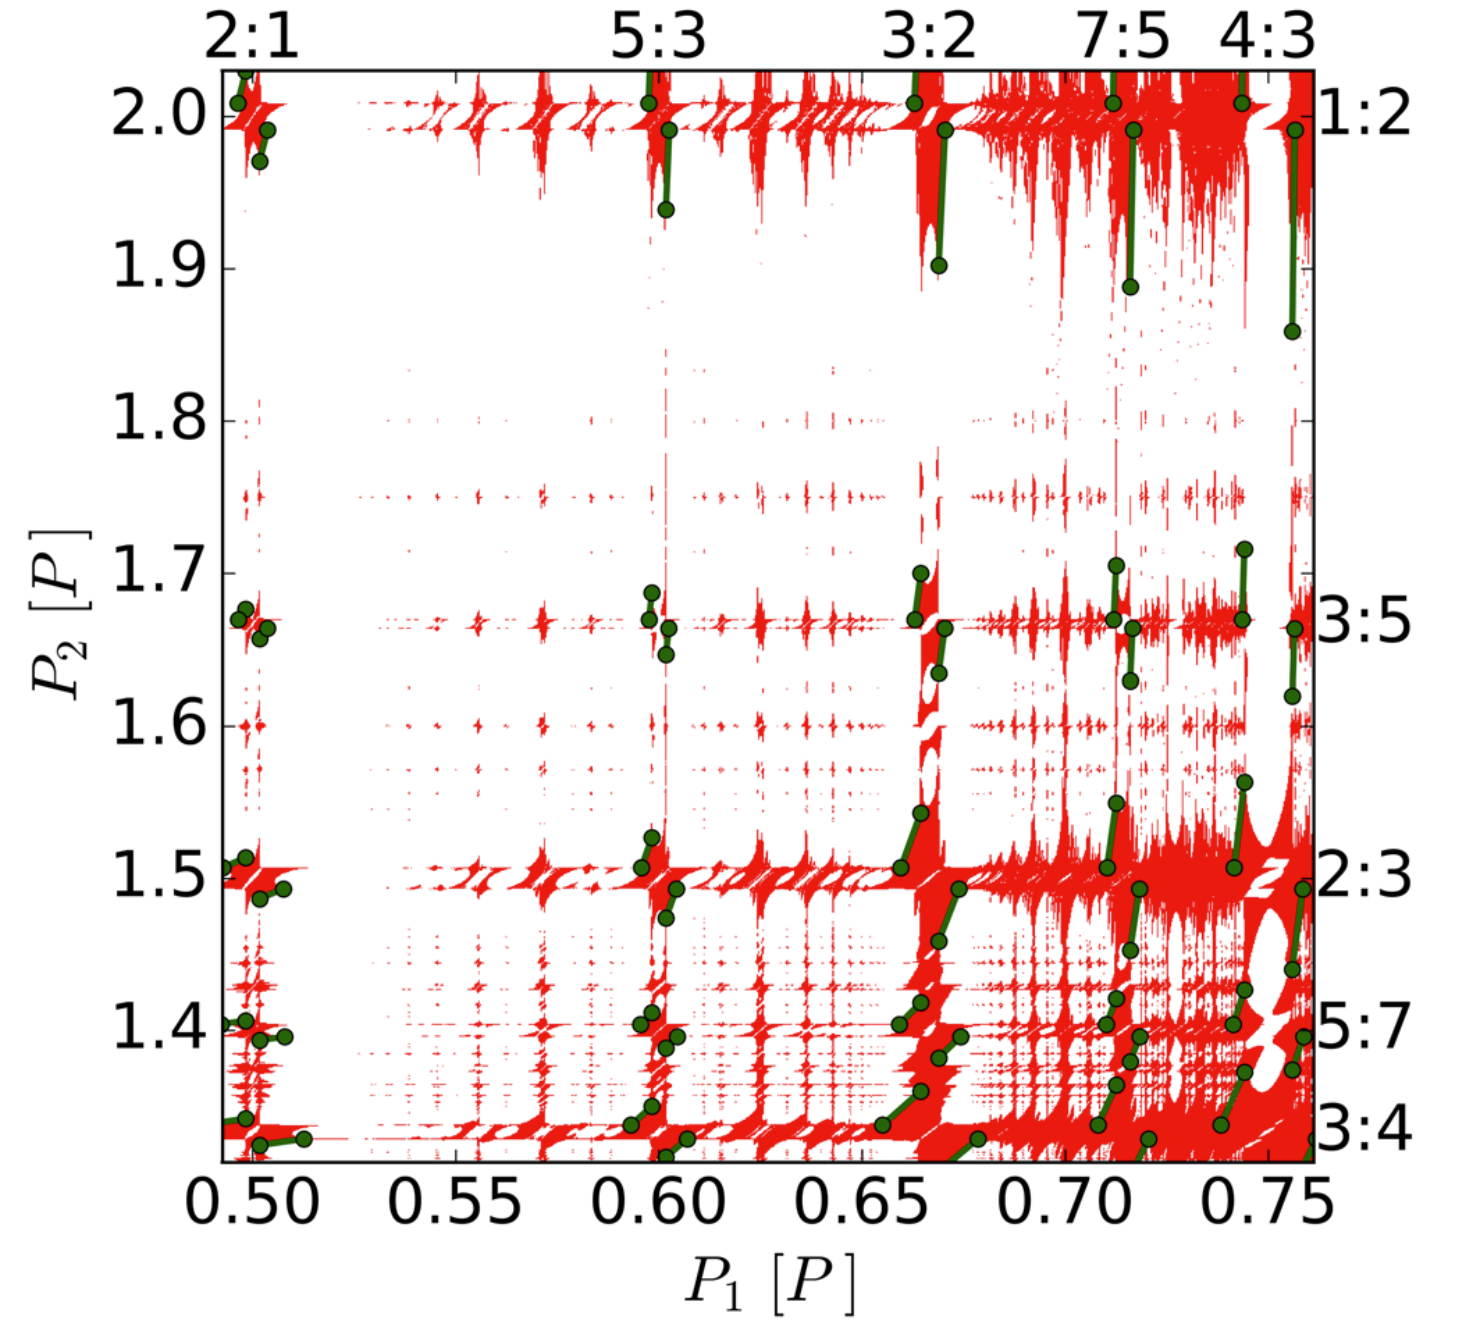
</div>

In [1]:
import numpy as np
import rebound
import matplotlib.pyplot as plt
from rebound.interruptible_pool import InterruptiblePool

In [2]:
def simulation(param):
    P1, P2 = param
    ecc1, ecc0, ecc2 = 0.003, 0.070, 0.016
    mu1, mu2 = 36e-6, 28e-6
    omega1, omega0, omega2 = -0.4, -0.86, 0
    P_0, lambda_0 = 0.05, 0

    # start simulation
    sim = rebound.Simulation()
    sim.units = ('yr', 'AU', 'Msun')

    # add star, planet 1, planet 2
    sim.add(m=1.)
    sim.add(m=mu1, P=P1, e=ecc1, omega=omega1)
    sim.add(m=mu2, P=P2, e=ecc2, omega=omega2)
    ps = sim.particles
    ps[1].r = ps[1].a*(ps[1].m/3/ps[0].m)**(1/3)
    ps[2].r = ps[2].a*(ps[2].m/3/ps[0].m)**(1/3)
    
    # add test particle
    sim.add(P=P_0, l=lambda_0, e=ecc0, omega=omega0)
    sim.move_to_com()
    sim.integrator = "whfast"
    sim.dt = sim.particles[1].P/20
    sim.collision = "direct"
    
    sim.init_megno()
    
    # calculate megno
    try:
        sim.integrate(1e5*2.*np.pi*P_0, exact_finish_time=0)
        megno = sim.calculate_megno() 
        return megno
    except rebound.Collision:
        return 10.
    except rebound.Escape:
        return 10. # At least one particle got ejected, returning large MEGNO.

In [3]:
Ngrid_x = 200
Ngrid_y = 200
P_0 = 0.05

r10 = np.linspace(0.49,0.76,Ngrid_x)
r20 = np.linspace(1.3,2.04,Ngrid_y)
parameters = [[P_0*x, P_0*y] for x in r10 for y in r20]

pool = InterruptiblePool()
results = pool.map(simulation,parameters)

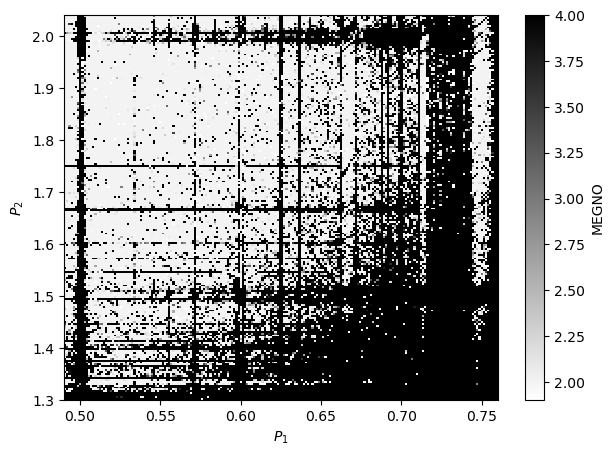

In [4]:
results2d = np.array(results).reshape(Ngrid_y,Ngrid_x)
fig = plt.figure(figsize=(7,5))
ax = plt.subplot(111)
extent = [min(r10),max(r10),min(r20),max(r20)]
ax.set_xlim(extent[0],extent[1])
ax.set_xlabel(r"$P_1$")
ax.set_ylim(extent[2],extent[3])
ax.set_ylabel(r"$P_2$")
im = ax.imshow(results2d.transpose(), interpolation="none", vmin=1.9, vmax=4, cmap="binary", origin="lower", aspect='auto', extent=extent)
cb = plt.colorbar(im, ax=ax)
cb.set_label("MEGNO")